In [2]:
import numpy as np
import random
# Affichage graphique

#%matplotlib notebook 
# enable interactivity of plots
# attention a bien fermer les fenetres plt après chaque visualisalgèbreation

%matplotlib inline
import matplotlib.pyplot as plt
import time
import networkx as nx
from collections import deque

# <center> TP3 - Flot et couplage </center>
<center> 2023/2024 - T. Godin, L. Naert </center>
<center> IUT de Vannes, BUT Informatique </center>

## Maximiser les flots (Séance 1)


En théorie des graphes, un réseau de flot est un graphe orienté où chaque arête possède une capacité et peut recevoir un flot ([wikipédia](https://fr.wikipedia.org/wiki/R%C3%A9seau_de_flot)).

Un problème classique de théorie des graphes est l’optimisation du flot dans un réseau. Ce problème consiste à trouver un flot réalisable depuis une source unique et vers un puits unique qui soit maximum

Un exemple d'un tel problème est "on représente un réseau de communication par un graphe dont chaque cable (arc) possède un débit maximal (on parlera de __capacité__ de l'arc). Quel est le débit maximum du réseau pour envoyer des fichier entre un émeteur (la __source__) et un recepteur (le __puits__) ?"

Autre contextualisation possible du même problème : on représente un réseau de distribution d'eau par un graphe : chaque sommet est une intersection et chaque arc est un tuyau avec un certain diamètre (capacité de l'arc). Quelle quantité d'eau maximale peut-on amener de la source au puits ? 

Et plein d'autres exemples existent...

Formalisons un peu :


$G = (S, A)$ est un graphe orienté avec  une fonction de _capacité_ $c : S\times S \to \mathbb{N}$ tel que

- $\forall (u, v) \in A$, $c(u, v) \geq 0$

- $\forall (u, v) \notin A$, $c(u, v) = 0$


Dans ce graphe on distingue 2 sommets particuliers
- $s$ : source ($d^- = 0$, pas d'arêtes entrantes)
- $t$ : puits ($d^+ = 0$, pas d'arêtes sortantes)

Sur un tel graphe, un _flot_ est  est une fonction $f : S^2 \to \mathbb{R}$ tq

- **Contraintes de capacité** : $f(u,v) \le c(u,v)$ (la quantité de flot sur un arc ne dépasse pas la capacité de cet arc)

- **Anti-symétrie** $f(u,v) = - f(v,u)$

- **Conservation du flot** $\sum_{w \in S} f(u,w) = 0$ , sauf si $u=s$ ou $u=t$ (sur chaque sommet sauf s et t, la somme des flots entrants est égale à la somme des flots sortants)

La _valeur_ totale du flot est $\sum_{(s,u) \in A} f(s, u) = \sum_{(v,t) \in A} f(v, t)$


Voici un exemple de graphe orienté avec capacité (la source et le puits sont en vert). L'illustration a été réalisée en utilisant la bibliothèque `networkx`:

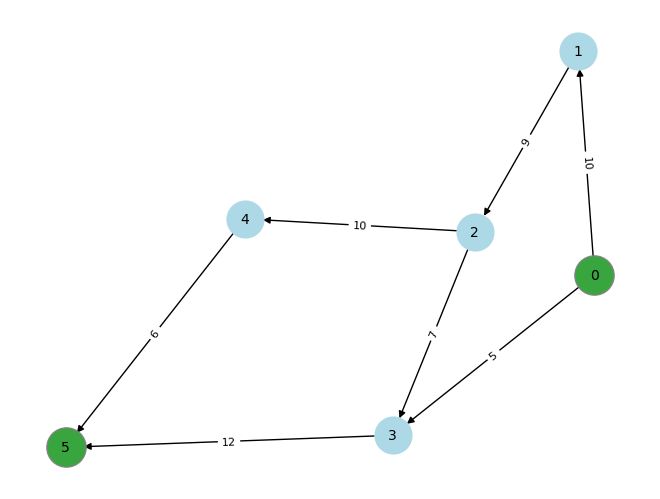

In [3]:
capacity_matrix = np.array([
    [0, 10, 0, 5, 0, 0],
    [0, 0, 9, 0, 0, 0],
    [0, 0, 0, 7, 10, 0],
    [0, 0, 0, 0, 0, 12],
    [0, 0, 0, 0, 0, 6],
    [0, 0, 0, 0, 0, 0]
])

source = 0
puits = 5

# Create a directed graph from the capacity matrix
G = nx.DiGraph()
for i in range(len(capacity_matrix)):
    for j in range(len(capacity_matrix[0])):
        if capacity_matrix[i][j] > 0:
            G.add_edge(i, j, capacity=capacity_matrix[i][j])
            
for u, v, data in G.edges(data=True):
    capacity = data['capacity']
    
# Draw the graph with edge labels
pos = nx.spring_layout(G)
labels = {edge: f"{G.edges[edge]['capacity']}" for edge in G.edges}
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_color='black')
options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}
nx.draw_networkx_nodes(G, pos, nodelist=[source, puits], node_color="tab:green", **options)
#nx.draw_networkx_edges(G, pos, edge_color='edge_colors', width=3, edge_cmap=plt.cm.Blues, edge_vmin=0, edge_vmax=1)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

plt.show()


Pour résoudre ce problème de flot, on va implémenter l'algorithme d'Edmond-Karp, une variante de l'algorithme Ford-Fulkerson où le chemin augmentant (dans le graphe résiduel) est donné par le plus court chemin de capacité non nulle entre $s$ et $t$.

Une implémentation interactive est disponible [ici](https://algorithms.discrete.ma.tum.de/graph-algorithms/flow-ford-fulkerson/index_en.html)

En pseudo-code, l'algorithme est le suivant :



`Edmonds-Karp`


**Inputs** Etant donné un graphe $G=(S,A)$ avec une capacité $c$, une source $s$, et un puits $t$

**Output** Calcule un flot $f$ de $s$ à $t$ de valeur maximum

1. $f(u, v) \leftarrow 0$ pour chaque arc $(u,v)$
2. Trouver le plus court chemin augmentant $p$ grace à un parcours en largeur
3. Tant qu'il y a un chemin $p$ de $s$ à $t$ dans le graphe résiduel
   
	1. Chercher la capacité de $p$ : $c_{f}(p)= \min \{c_{f}(u,v):(u,v)\in p\}$
	2. pour chaque arete $(u,v) \in p$:

		1. $f(u,v) \leftarrow f(u,v) + c_{f}(p)$ *(ajoute le flot)*
		2. $f(v,u) \leftarrow f(v,u) - c_{f}(p)$ *(le flot pourra être retiré d'une arete si le total est amélioré)*


Remarquer que vous avez besoin : 
1) de faire le parcours en largeur d'un graphe
2) de trouver "le plus court chemin augmentant"
3) de savoir calculer le "graphe résiduel"

Une implémentation du __parcours en largeur__ (Breadth-First Search - BFS) vous est fournie. Cette fonction donne la liste du sommet parent de chaque sommet en considérant le plus court chemin depuis la source en paramètre. Si un noeud n'a pas de parent (source), son parent est noté -1.

Note : Un parcours en largeur permet d'avoir la distance d'un noeud source aux autres noeuds puisqu'il déploie chacun des étages du graphe avant de passer au suivant. Cela sera utile pour calculer "le plus court chemin augmentant".

In [4]:
def bfs(graph,source):
    """
    renvoie la liste du sommet parent de chaque sommet en considérant le plus court chemin depuis la source en paramètre
    
    
   :param graph sous la forme d'une matrice de capacité
   :param source l'indice du noeud de départ
   :return: liste de sommets parents
   :rtype: list
    """
    visited = [False] * len(graph)
    parent = [-1] * len(graph)
    queue = deque() # double ended queue : possible d'ajouter et de retirer des éléments par les deux bouts 
    # -> ici utilisé comme une file
    queue.append(source)
    visited[source] = True

    while queue: # tant que la file n'est pas vide
        u = queue.popleft()
        for v, capacity in enumerate(graph[u]): #enumerate donne l'indice de l'élément ! v indice, capacity, la capacité
            if not visited[v] and capacity > 0: #Si la capacité est supérieure à 0 (existance d'une arete de u à v) 
                #et qu'on est pas déjà passé par v
                queue.append(v) # on ajoute v à la file
                visited[v] = True # on anonce qu'on a visité v
                parent[v] = u #u est rajouté dans les parents -> pour avoir le chemin, il suffit de remonter dans les parents 
                #du puits.

    return parent



bfs(capacity_matrix,source) 
#[-1, 0, 1, 0, 2, 3] : le parent du puits (sommet n°5) est le sommet n°3, dont le parent est le sommet n°0
#-> on a un chemin de la source au puits !

[-1, 0, 1, 0, 2, 3]

Le __chemin augmentant le plus court__ est le plus court chemin (en nombre d'arcs) pour aller d'un point $a$ à un point $b$ (ici, pour aller de la source au puits). Ce chemin est obtenu en remontant dans la liste de parent donné par le parcours en largeur. 

La capacité de ce chemin est la capacité minimum des capacités des arcs le composant (capacité limitante).

> __Question 1 (Chemin augmentant le plus court)__ : utiliser `bfs` afin d'écrire une fonction `shortest_augmenting_path(graph_matrix,source,sink)` qui retourne 1) le plus court chemin augmentant sous la forme d'une liste dans le graphe en paramètre, 2) la capacité de ce chemin. On retournera une liste vide si `sink` ("puits") n'est pas accessible depuis `source`

In [5]:
def shortest_augmenting_path(graph_matrix,source,sink):
    """
    renvoie le plus court chemin augmentant de source à sink
    
    
   :param array graph_matrix graphe sous la forme d'une matrice de capacité
   :param int source l'indice du sommet de départ
   :param int sink l'indice du sommet d'arrivée
   :return: liste des sommets formant le chemin, capacité du chemin
   :rtype: list, int
    """
    path=[]
    capacity = 3
   
    return path,capacity


try:
    capacity_matrix = np.array([
        [0, 10, 0, 5, 0, 0],
        [0, 0, 9, 0, 0, 0],
        [0, 0, 0, 7, 10, 0],
        [0, 0, 0, 0, 0, 12],
        [0, 0, 0, 0, 0, 6],
        [0, 0, 0, 0, 0, 0]
    ])
    assert shortest_augmenting_path(capacity_matrix, 0, 5) == ([0, 3, 5], 5)
    print("shortest_augmenting_path : OK")
except:
    print("shortest_augmenting_path : ERREUR")

shortest_augmenting_path : ERREUR


Un __graphe résiduel__ doit être calculé à chaque itération de la boucle. Il s'agit d'un graphe de capacité auquel on a soustrait le flot. Ainsi, si, sur un arc, le flot est égal à la capacité, le graphe résiduel correspondant aura une capacité de 0 sur cet arc qui ne pourra donc plus être empruntée lors du parcours en largeur. 

> __Question 2 (Graphe residuel)__ : écrire une fonction `residual_graph(capacity_graph, flow_graph)` renvoyant le graphe résiduel à partir d'un graphe de capacité et d'un graphe de flot (tous deux sous forme matricielle).


In [6]:
def residual_graph(capacity_graph, flow_graph):
    """
    renvoie le graphe résiduel
    
    
   :param array capacity_graph graphe de capacité
   :param array flow_graph graphe de flot
   :return: graphe résiduel sous la forme d'une matrice de capacité
   :rtype: array
    """
    
    
    return 0

    
capacity_matrix = np.array([
  [0, 10, 0, 5, 0, 0],
  [0, 0, 9, 0, 0, 0],
  [0, 0, 0, 7, 10, 0],
  [0, 0, 0, 0, 0, 12],
  [0, 0, 0, 0, 0, 6],
  [0, 0, 0, 0, 0, 0]
])

flow_matrix = np.array([
  [ 0,  0,  0,  5,  0,  0],
  [ 0,  0,  0 , 0,  0,  0],
  [ 0,  0,  0,  0,  0,  0],
  [-5,  0 , 0,  0,  0,  5],
  [ 0,  0 , 0,  0,  0,  0],
  [ 0,  0,  0, -5,  0,  0],
])

residual_graph(capacity_matrix,flow_matrix)


0

Rappel de l'algorithme complet : 

`Edmonds-Karp`


**Inputs** Etant donné un graphe $G=(S,A)$ avec une capacité $c$, une source $s$, et un puits $t$

**Output** Calcule un flot $f$ de $s$ à $t$ de valeur maximum

1. $f(u, v) \leftarrow 0$ pour chaque arc $(u,v)$
2. Trouver le plus court chemin augmentant $p$ grace à un parcours en largeur
3. Tant qu'il y a un chemin $p$ de $s$ à $t$ dans le graphe résiduel
   
	1. Chercher la capacité de $p$ : $c_{f}(p)= \min \{c_{f}(u,v):(u,v)\in p\}$
	2. pour chaque arete $(u,v) \in p$:

		1. $f(u,v) \leftarrow f(u,v) + c_{f}(p)$ *(ajoute le flot)*
		2. $f(v,u) \leftarrow f(v,u) - c_{f}(p)$ *(le flot pourra être retiré d'une arete si le total est amélioré)*


> __Question 3 (Edmonds-Karp)__ : à l'aide des fonctions précédement définies, écrire une fonction `edmonds_karp(capacity_graph, source, sink)` renvoyant un entier correspondant au flot maximal pour aller de la `source` au puits `sink` ainsi que la matrice de ce flot.

In [7]:
def edmonds_karp(capacity_graph, source, sink):
    """
    renvoie le flot max ainsi que la matrice de flot correspondant
    
    
   :param array capacity_graph graphe de capacité
   :param int source indice de la source
   :param int sink indice du puits
   :return: flot max, matrice de flot
   :rtype: int, array
    """
    max_flow = 0
    flow_matrix = np.zeros((len(capacity_graph), len(capacity_graph)),int) #une matrice de la taille de la matrice de 
    #capacité avec que des 0

    return max_flow,flow_matrix


try:
    capacity_matrix = np.array([
        [0, 10, 0, 5, 0, 0],
        [0, 0, 9, 0, 0, 0],
        [0, 0, 0, 7, 10, 0],
        [0, 0, 0, 0, 0, 12],
        [0, 0, 0, 0, 0, 6],
        [0, 0, 0, 0, 0, 0]
    ])
    max_flow_value = edmonds_karp(capacity_matrix, 0, 5)
    assert max_flow_value[0] == 14
    
    
    capacity_matrix_cormen=np.array([
        [0 ,16,13,0 ,0 ,0 ],
        [0 ,0 ,10,12,0 ,0 ],
        [0 ,4 ,0 ,0 ,14,0 ],
        [0 ,0 ,9 ,0 ,0 ,20],
        [0 ,0 ,0 ,7 ,0 ,4],
        [0 ,0 ,0 ,0 ,0 ,0 ]    
    ])
    max_flow_value = edmonds_karp(capacity_matrix_cormen, 0, 5)
    assert max_flow_value[0] == 23
    
    
    print("edmonds_karp : OK")
except:
    print("edmonds_karp : ERREUR")
    
    

edmonds_karp : ERREUR


La fonction `edmonds_Karp_draw` appelle la fonction `edmonds_Karp` et trace le graphe de flot correspondant à la matrice de capacité donnée en paramètre. 

Plus un arc est large, plus sa capacité est grande. Plus un arc est foncée, plus son flot s'approche de la capacité.

In [8]:

def edmonds_Karp_draw(capacity_matrix,source,sink, pos = False) :
    """
    Dessine le flot obtenu après application de l'algorithme d'Edmonds-Karp.
    
    :param array capacity_matrix matrice de capacite
    :param int source indice de la source
    :param int sink indice du puits
    :param dict pos positions des sommets (par défaut non précisées)
    """
    
    
    max_flow_value,flow_matrix = edmonds_karp(capacity_matrix, source, sink)
    print(f"Maximum Flow: {max_flow_value}")

    # Create a directed graph from the capacity matrix
    G = nx.DiGraph()
    for i in range(len(capacity_matrix)):
        for j in range(len(capacity_matrix[0])):
            if capacity_matrix[i][j] > 0:
                G.add_edge(i, j, capacity=capacity_matrix[i][j],flow=flow_matrix[i][j])

    # Define the edge colors based on flow and capacity
    edge_colors = []
    for u, v, data in G.edges(data=True):
        capacity = data['capacity']
        flow = capacity - data['flow']
        edge_colors.append(flow/capacity)
        
        
    # Draw the graph with edge labels
    if not (pos) :
        pos = nx.shell_layout(G)

    labels = {edge: f"{G.edges[edge]['flow']}/{G.edges[edge]['capacity']}" for edge in G.edges}
    capacity=[data['capacity'] for u, v, data in G.edges(data=True)]
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=15, font_color='black')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=capacity, edge_cmap=plt.cm.Blues_r, edge_vmin=0, edge_vmax=1)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)
    options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}
    nx.draw_networkx_nodes(G, pos, nodelist=[source, sink], node_color="tab:green", **options)

    plt.show()
    


> __Question 4 (application)__ : Tracer les graphes de flot correspondant à capacity_matrix et capacity_matrix_cormen des exemples précédents.

> __Question 5 (application)__ : Utiliser les fonctions précédentes pour résoudre le problème de flot décrit sur [wikipédia](https://fr.wikipedia.org/wiki/Algorithme_d%27Edmonds-Karp). Obtenez-vous la même solution ? 

Passons à un autre problème, nous verrons le lien avec le flot un peu plus tard...

## Couplage maximum dans un graphe biparti (Séance 2)

Le problème du couplage maximum dans un graphe biparti modélise, par exemple, l'affectation de bénévoles (ayant des compétences spécifiques) à certaines tâches (individuelles et concomitantes).

> __Question 6 (Appariements et mariages)__ : expliquer pourquoi ce problème ne peut pas être résolu avec l'algorithme des mariages stables.

Réponse : ...

La modélisation naturelle de ce problème se fait à l'aide de graphes _bipartis_, c'est-à-dire un graphe $G=(S,A)$ où l'ensemble des sommets $S$ peut être partitionné en deux ensemble $S_1, S_2$ tels que

 - $S_1 \cup S_2 = S$
 - $S_1 \cap S_2 = \emptyset$
 - Il n'y a aucune arête entre deux sommets de $S_1$ ni entre sommets de $S_2$

Le code suivant modélise graphiquement un tel problème. Ici, par exemple, Gaspard a des compétences en premiers secours et en cuisine alors que Lily ne s'y connait qu'en premiers secours. 

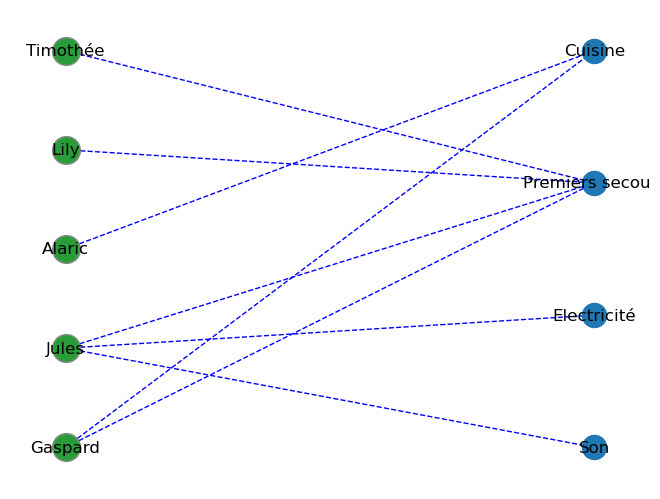

In [9]:
G=nx.Graph()

G.add_node('0',name='Alaric')
G.add_node('1',name='Gaspard')
G.add_node('2',name='Jules')
G.add_node('3',name='Lily')
G.add_node('4',name='Timothée')
G.add_node('5',name='Cuisine')
G.add_node('6',name='Electricité')
G.add_node('7',name='Premiers secours')
G.add_node('8',name='Son')

# Add edges by defining weight and label
G.add_edge('0','5',color="b", style = "dashed")
G.add_edge('1','5',color="b", style = "dashed")
G.add_edge('1','7',color="b", style = "dashed")
G.add_edge('2','6',color="b", style = "dashed")
G.add_edge('2','7',color="b", style = "dashed")
G.add_edge('2','8',color="b", style = "dashed")
G.add_edge('3','7',color="b", style = "dashed")
G.add_edge('4','7',color="b", style = "dashed")


# to_numpy_array renvoie la matrice d'adjacence sous forme d'un np.array
A=nx.to_numpy_array(G)

# bipartite.sets calcule et renvoie les sous ensembles S1 et S2 du graphe biparti
top = nx.bipartite.sets(G)[0]
# dictionnaire : indices et noms des sommets.
names = nx.get_node_attributes(G,'name')

#edges renvoie les aretes du graphe, avec data = True, on récupère les informations supplémentaires, ici, la couleur.
#print(G.edges(data=True))
edge_style=[data['style'] for u, v, data in G.edges(data=True)]

#bipartite_layout : positionne les noeuds sur deux lignes en fonction du graphe et des ensembles S1 et S2.
nx.draw(G,pos=nx.bipartite_layout(G,top),labels=names,with_labels=True,edge_color='b', style = edge_style)
options = {"edgecolors": "tab:gray", "node_size": 400, "alpha": 0.9}
nx.draw_networkx_nodes(G, pos=nx.bipartite_layout(G,top), nodelist=top, node_color="tab:green", **options)

On cherche à attribuer une unique tache à chaque bénévole et un unique bénévole à chaque tâche de façon à ce que le plus de taches possibles soit réalisées (qu'il y ait le plus d'arêtes disjointes dans le couplage final).

L'algorithme de Hopcroft-Karp, utilisé ici permet d'obtenir le couplage maximum. On peut voir le résultat du couplage en lignes continues rouges. Remarquez que certaines taches peuvent ne pas être réalisées (c'est le cas de la tache "son" ici).

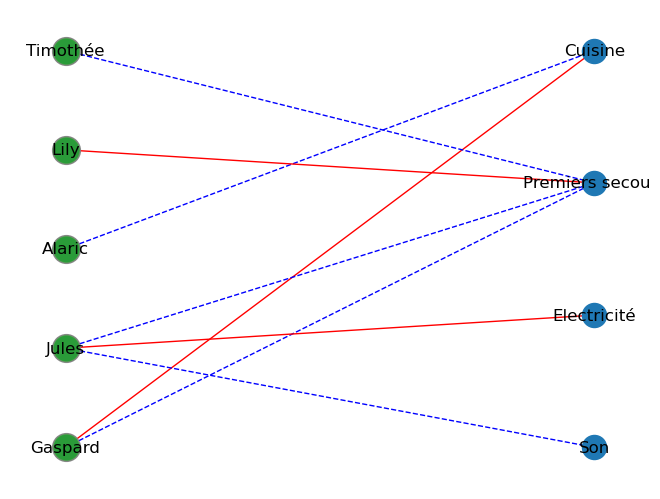

In [10]:
match=nx.bipartite.hopcroft_karp_matching(G, top_nodes=top)

key=match.keys()
for  u, v, data in G.edges(data=True):
    if u in key :
        if match[u]==v : 
            G.edges[u,v]['color']='r'
            G.edges[u,v]['style']="solid"
                 

edge_colors=[]   
            
for  u, v, data in G.edges(data=True):
    edge_colors.append(data['color'])

edge_style=[data['style'] for u, v, data in G.edges(data=True)]
nx.draw(G,pos=nx.bipartite_layout(G,top),labels=names,with_labels=True,edge_color=edge_colors, style=edge_style)
options = {"edgecolors": "tab:gray", "node_size": 400, "alpha": 0.9}
nx.draw_networkx_nodes(G, pos=nx.bipartite_layout(G,top), nodelist=top, node_color="tab:green", **options)

Pour résoudre le problème de couplage biparti, on a utilisé l'algorithme de Hopcroft-Karp déjà implémenté dans la bibliothèque `networkx` mais on peut aussi résoudre un problème de couplage biparti en le considérant comme un problème de flot. Ainsi, il sera possible de réutiliser la fonction `edmonds-Karp` que vous avez développé.


On transforme un problème de couplage sur $(S_1\cup S_2, A)$  en un problème de flots en transformant les arêtes en arcs (dirigés de $S_1$ vers $S_2$) et en ajoutant une source $s$ reliée à tous les sommets de $S_1$ et un puits $t$ relié à tous les sommets de $S_2$. La capacité de tous les arcs est fixée à $1$.



> __Question 7 (transformation)__ : Écrire une fonction `couplage_to_capacity(matrix, s1, s2)` transformant une matrice d'adjacence `matrix` representant le couplage sur $(S_1\cup S_2, A)$ en une matrice de capacité représentant un problème de flots comme décrit plus haut. `s1` et `s2` sont des listes d'entiers contenant respectivement les indices des sommets de S1 et de S2.

In [11]:
def couplage_to_capacity(matrix, s1, s2):
    """
    Transforme une matrice d'adjacence en matrice de capacité avec sommet source et puits
    
    :param array capacity_matrix matrice de capacite
    :param list s1 indices des sommets de s1
    :param list s2 indices des sommets de s2
    
    :return matrice de capacité
    :rtype array
    
    """

    return np.zeros((3,3))

Le code suivant donne une illustration du graphe résultant (avec ajout de la source en indice 9 et du puits en 10) : 

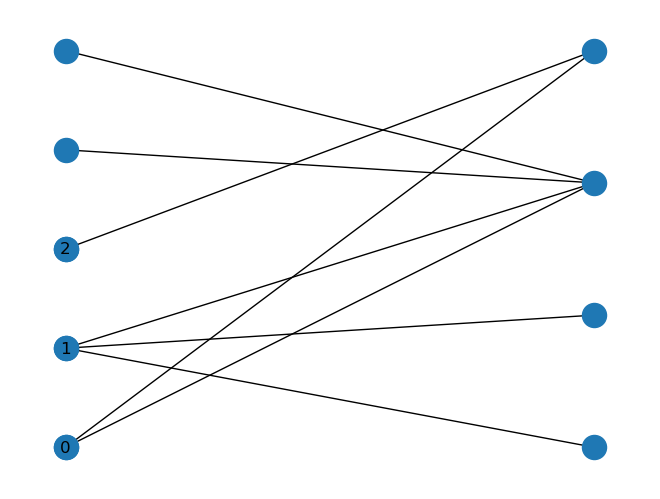

In [12]:
#Exemple d'affichage
G=nx.Graph()

G.add_node('0',name='Alaric')
G.add_node('1',name='Gaspard')
G.add_node('2',name='Jules')
G.add_node('3',name='Lily')
G.add_node('4',name='Timothée')
G.add_node('5',name='Cuisine')
G.add_node('6',name='Electricité')
G.add_node('7',name='Premiers secours')
G.add_node('8',name='Son')

# Add edges by defining weight and label
G.add_edge('0','5',color="b", style = "dashed")
G.add_edge('1','5',color="b", style = "dashed")
G.add_edge('1','7',color="b", style = "dashed")
G.add_edge('2','6',color="b", style = "dashed")
G.add_edge('2','7',color="b", style = "dashed")
G.add_edge('2','8',color="b", style = "dashed")
G.add_edge('3','7',color="b", style = "dashed")
G.add_edge('4','7',color="b", style = "dashed")


s1,s2 = nx.bipartite.sets(G)
s1Arr = np.asarray([int(i) for i in list(s1)])
s2Arr = np.asarray([int(i) for i in list(s2)])
#print(s1Arr,s2Arr)
nx.draw(G,pos=nx.bipartite_layout(G,s1))

#Changer un graphe en matrice d'adjacence
match_matrix=nx.to_numpy_array(G)

capacity_matrix=couplage_to_capacity(match_matrix,s1Arr, s2Arr )
#print(match_matrix)
#print(capacity_matrix)

#Permet des donner des positions aux noeuds. Elles seront réutilisées à l'appel d'edmonds-karp draw
pos_flow=nx.bipartite_layout(nx.from_numpy_array(nx.to_numpy_array(G)),s1Arr)
pos_flow[9]=np.array([-2,0]) #source
pos_flow[10]=np.array([2,0]) #puits

Gf=nx.from_numpy_array(capacity_matrix,create_using=nx.DiGraph)
nx.draw(Gf,pos=pos_flow,with_labels=True)

> __Question 8 (Edmonds-Karp pour couplage max)__ : Utiliser les fonctions précédentes pour résoudre ce problème d'affectation de taches en utilisant l'algorithme d'edmonds-Karp. Illustrer le résultat avec un graphe de capacité.

Maximum Flow: 3.0


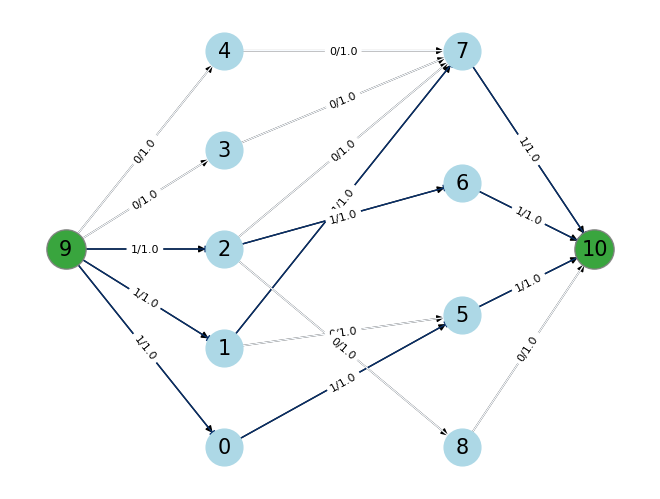

> __Question 9 (exemples et carte blanche)__ : La fonction `nx.bipartite.random_graph(n,m,p)` permet de créer des graphes bipartis aléatoires de $n$ sommets dans le premier ensemble et $m$ sommets dans le deuxième avec un probabilité de création d'arêtes égale à $p$. Utiliser cette fonction pour créer des exemples à résoudre. Testez vos méthodes, commentez les résultats et n'hésitez pas à soigner l'affichage des graphes ! 

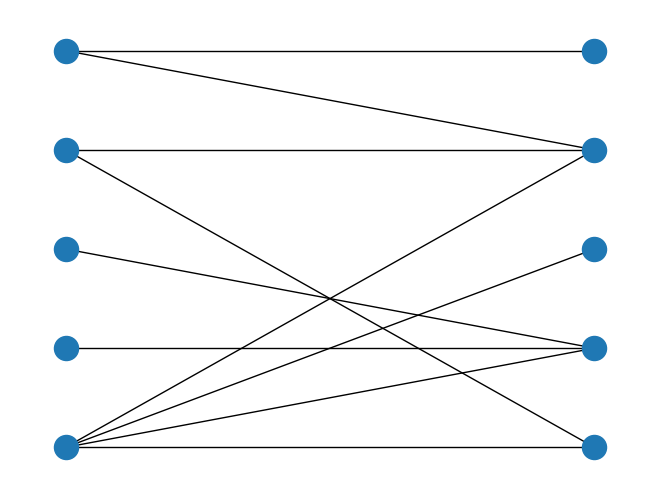